# Defensive Perception
## MNIST Hands-On Notebook

This Notebook is an example on how to use the Defensive Perception Metrics with the MNIST Dataset. The Dataset is shifted by 90 Degrees in 5 Degree Steps but only traines on the standard MNIST Dataset. 


In [1]:
!pip install tensorflow==2.8.0
!pip install keras==2.8.0
!pip install matplotlib
!pip install scipy

In [2]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from scipy import ndimage

### Prepare the Data

As mentioned in the description the dataset will be rotated anticlockwise in 5 degree steps from 0 to 90 degrees. 

Rotations Finished: 19/19
Done


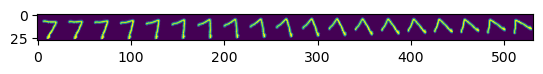

In [3]:
# Prepare the Dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Convert the labels to one hot labels
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

# The Rotations on which the model is tested later is defined here
ROTATIONS = [rot for rot in np.arange(0, 91, 5)]

# List that stores the Datasets for each rotation
rotated_testset = []

# Rotate the actual images and store them
for i, rotation in enumerate(ROTATIONS):
    x_test_rotated = ndimage.rotate(x_test, rotation, reshape=False, axes=(1, 2))
    rotated_testset.append([x_test_rotated, y_test])
    print("\rRotations Finished: {}/{}".format(i+1, len(ROTATIONS)), end="")

print("\nDone")

# Check one Sample in the rotated data
check_rotations = np.concatenate([img[0][0] for img in rotated_testset], axis=1)
plt.imshow(check_rotations)
plt.show()


### Train the MNIST Model

For our Model we chose a simple sequential model with only one hidden layer. The model is then trained for 100 epochs with a batch size of 500 and a dropout rate of 0.5.

In [4]:
# Train the Model
from keras.layers import *
from keras.models import *
from tensorflow.keras.optimizers import Adam


def MNIST_Model(shape=(28, 28, 1), training_var=True, dropout=0.2):
    """ MNIST-Model
    Keras model build like described in "Cuepervision: Self-supervised learning for continuous domain adaptation
    without catastrophic forgetting
    
    Args:
        shape: Shape of the model input
        training_var: Set this to True when using dropout
        dropout: Percent of connections to drop
    
    """
    input_layer = Input(shape=shape)
    flatten_layer = Flatten()(input_layer)
    fully_connected_relu = Dense(512, activation="relu")(flatten_layer)
    dropout = Dropout(dropout)(fully_connected_relu, training=training_var)
    output_dense_layer = Dense(10, activation="softmax")(dropout)
    model = Model(inputs=input_layer, outputs=output_dense_layer)

    model.compile(
        optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model


BATCH_SIZE = 500
STEPS_PER_EPOCH = int(len(x_train) / BATCH_SIZE)
EPOCHS = 100


model = MNIST_Model(dropout=0.5)

history = model.fit(
    x=x_train, 
    y=y_train, 
    validation_data = [x_test, y_test],
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    verbose=1
)

model.save_weights("./Models/MNIST")

del model

Epoch 1/100
120/120 [==============================] - 2s 14ms/step - loss: 12.5147 - accuracy: 0.8094 - val_loss: 1.7027 - val_accuracy: 0.8420
Epoch 2/100
120/120 [==============================] - 1s 12ms/step - loss: 1.1586 - accuracy: 0.8504 - val_loss: 0.8860 - val_accuracy: 0.8510
Epoch 3/100
120/120 [==============================] - 1s 12ms/step - loss: 0.7124 - accuracy: 0.8669 - val_loss: 0.6980 - val_accuracy: 0.8702
Epoch 4/100
120/120 [==============================] - 1s 12ms/step - loss: 0.5369 - accuracy: 0.8834 - val_loss: 0.6414 - val_accuracy: 0.8790
Epoch 5/100
120/120 [==============================] - 1s 12ms/step - loss: 0.4354 - accuracy: 0.9002 - val_loss: 0.5480 - val_accuracy: 0.8890
Epoch 6/100
120/120 [==============================] - 1s 12ms/step - loss: 0.3715 - accuracy: 0.9089 - val_loss: 0.5041 - val_accuracy: 0.8993
Epoch 7/100
120/120 [==============================] - 1s 12ms/step - loss: 0.3259 - accuracy: 0.9166 - val_loss: 0.4859 - val_accuracy

120/120 [==============================] - 1s 11ms/step - loss: 0.1520 - accuracy: 0.9630 - val_loss: 0.3967 - val_accuracy: 0.9477
Epoch 58/100
120/120 [==============================] - 1s 12ms/step - loss: 0.1467 - accuracy: 0.9646 - val_loss: 0.3678 - val_accuracy: 0.9506
Epoch 59/100
120/120 [==============================] - 1s 12ms/step - loss: 0.1375 - accuracy: 0.9670 - val_loss: 0.3436 - val_accuracy: 0.9490
Epoch 60/100
120/120 [==============================] - 1s 12ms/step - loss: 0.1357 - accuracy: 0.9671 - val_loss: 0.3552 - val_accuracy: 0.9519
Epoch 61/100
120/120 [==============================] - 1s 12ms/step - loss: 0.1348 - accuracy: 0.9669 - val_loss: 0.3425 - val_accuracy: 0.9526
Epoch 62/100
120/120 [==============================] - 1s 12ms/step - loss: 0.1403 - accuracy: 0.9660 - val_loss: 0.3753 - val_accuracy: 0.9495
Epoch 63/100
120/120 [==============================] - 1s 12ms/step - loss: 0.1282 - accuracy: 0.9679 - val_loss: 0.3578 - val_accuracy: 0.948

## The uncertainty calculation

The basic idea of the uncertainty calculations is to do multiple forward passes and look at the differences between the results. The main task was to find a metric that can display these results in the best possible way.


### Modified Categorical Cross-entropy Metric
To measure the uncertainty over multiple forward passes from each forward pass the one-hot encoded output vector $\textbf{y}_fwp$ is taken and the hits for each class a accumulated. 
The retrieved vector $\textbf{v}_{hC}$ shows the distribution of hits over all class for the amount of applied forward passes. As only the classes which are predicted in one of the forward passes are of interested any class with $0$ hits is removed from this vector, so that  $\textbf{v}_{hC} \setminus \{0\}$, with $i$ being the length of this vector.
From this vector the class with the maximum hits is assumed to be the true class, hence a pseudo true class $max(v_{hC})$. 
As in the hit vector $\textbf{v}_hC$ only the classes which where hit are considered for the sum over the classes also only over the hit classes $C_h$ it is accumulated.

The here presented formula fulfilling the requirements is:
\begin{align}
    CE_u = 1-\frac{e^{\frac{max(\textbf{v}_{hC})}{n_{fwp}}}}{\sum_{i}^{C_h} e^{\frac{\textbf{v}_{hC}i}{n_{fwp}}}}
    % This metric doesn't reach one, and has an exponential increase
\end{align}

To have a better readability the uncertainty measurement is subtracted from $1$ to have a low score near $0$ when the uncertainty of the neural network is low, and a value near 1 when the uncertainty is critical.

In [5]:
def categorical_crossentropy_metric_single(result_vector):
    n_classes = len(result_vector)
    fwp = sum(result_vector)
    hit_vector = result_vector

    while 0 in hit_vector:
        hit_vector.remove(0)

    denominator = 0
    
    hit_vector = [element / float(fwp) for element in hit_vector] 

    for element in hit_vector:
        denominator += np.exp(element)
    #    
    val = 1-(np.exp(max(hit_vector)) / denominator)

    
    return val



def categorical_crossentropy_metric(result_vector: np.array, n_categories: int):    
    m_carlo = []
    fwp = result_vector.shape[0]

    for pos in range(len(result_vector[0])):
        # One pass for every predicted image in values parameter
        values_counted = [0] * n_categories
        for v in range(n_categories):
            values_counted[v] = np.count_nonzero(result_vector[:, pos] == v)

        m_carlo.append(categorical_crossentropy_metric_single(values_counted))

    return m_carlo

In [6]:
n_fwp = 20
dropout_value = 0.4

errors = []
mcd = []
max_one_hot = []

# -------------------
errors_all = []
max_one_hot_all = []
#--------------------

# Load two seperate Models. One with dropout and one without
model_without_dropout = MNIST_Model(training_var=False)
model_without_dropout.load_weights("./Models/MNIST").expect_partial()
model_with_dropout = MNIST_Model(dropout=dropout_value)
model_with_dropout.load_weights("./Models/MNIST").expect_partial()

print("\r Process: {}/{}".format(0, len(rotated_testset)), end="")

for i, (x_rotated, y_rotated) in enumerate(rotated_testset):
    predictions = []
    for _ in range(n_fwp):
        prediction = model_with_dropout.predict(x_rotated)
        prediction = tf.argmax(prediction, -1)
        predictions.append(prediction)
    # m_carlo = hit_distribution_metric(np.array(predictions), 10)
    m_carlo = categorical_crossentropy_metric(np.array(predictions), 10)
    mcd.append(m_carlo)
    
    _, acc = model_without_dropout.evaluate(x_rotated, y_rotated, verbose=0)
    max_one_hot.append(np.sum(np.max(model_without_dropout.predict(x_rotated), axis=-1))/len(x_rotated))
    error = 1 - acc
    errors.append(error)
    print("\r Process: {}/{}".format(i+1, len(rotated_testset)), end="")

 Process: 19/19

The following code is just for plotting the results.

In [7]:
from typing import List
import matplotlib.patches as mpatches

def plot_mcd_results(
    indices: List,
    monte_carlo_dropout: List,
    error: List,
    max_one_hot: List,
    title: str,
    x_label: str,
):
    """Plots the results of the mcd calculations

    Args:
        indices: List of indices
        monte_carlo_dropout: list of monte carlo dropouts
        error: List of errors
        title: Title that is displayed above the matplotlib plot
        x_label: Description of the x-Axis
    """    
    acc_all = error
    
    x_labels = indices

    monte_carlo = monte_carlo_dropout
    
    for param in ["figure.facecolor", "axes.facecolor", "savefig.facecolor"]:
        plt.rcParams[param] = "#FFFFFF"

    for param in [
        "text.color",
        "axes.labelcolor",
        "xtick.color",
        "ytick.color",
    ]:
        plt.rcParams[param] = "0.0"

    figure = plt.figure(figsize=(25 * 1 / 2.54, 15 * 1 / 2.54))

    ax1 = figure.add_subplot(1, 1, 1)
    ax1.grid(color="#EEEEEE", axis="y")
    c = "#FF5500"
    red_dict = {
        "patch_artist": False,
        "boxprops": dict(color="#000000"),  # , facecolor=None),
        "capprops": dict(color="#000000"),
        "flierprops": dict(color="#000000", markeredgecolor="#000000"),
        "medianprops": dict(color=c, linewidth=4),
        "whiskerprops": dict(color="#000000"),
    }

    x_ticks = []
    pos = [h for h in range(len(indices))]
    ax1.boxplot(monte_carlo, positions=pos, labels=["asdf"] + ["asdf" for _ in range(len(indices)-1)], showmeans=True, **red_dict)  # , widths=3)
    
    x_ticks += pos

    ax1.plot(
        [h for h in range(len(indices))],
        acc_all,
        "o",
        label="error",
        color="#009682",
    )
    
    ax1.plot(
        [h for h in range(len(indices))],
        max_one_hot,
        "o",
        label="max one-hot",
        color="#00ABE7",
    )
        
    ax1.xaxis.grid(False)
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_labels)
    ax1.set_title(title, fontsize=20.0)
    ax1.set_ylim(-0.05, 1.05)
    ax1.set_ylabel("error / uncertainty", fontsize=15.0)
    ax1.set_xlabel(x_label, fontsize=15.0)
    
    handles, labels = ax1.get_legend_handles_labels()
    orange_patch = mpatches.Patch(color='#FF5500', label='uncertainty')
    green_box = mpatches.Arrow(0, 0, 1, 1, width=1, color="#55CC55", label='mean uncertainty')
    handles.append(orange_patch) 
    handles.append(green_box) 
    ax1.legend(handles=handles, loc="upper right")

    plt.tight_layout()
    plt.plot()

## Results

The plot below shows the results of our calculations. It can be observed, that the uncertainty value rises with an increased rotation value. The maximal one-hot value on the other hand doesn't provide enaugh information for us to rely on it to make statements on the model uncertainty with it. 

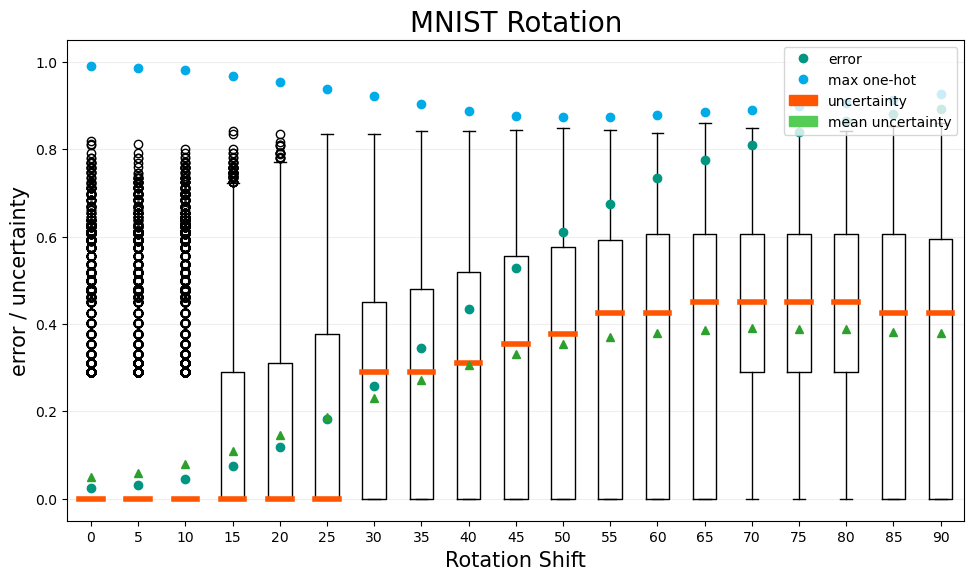

In [8]:
plot_mcd_results(ROTATIONS, mcd, errors, max_one_hot, "MNIST Rotation", "Rotation Shift")

### Video usage

Another experiment we conducted was to use the metric on an image segmentation model. The metric works almost the same with the only difference, that the metric is applied to every pixel of the predictions. This results in one uncertainty value per pixel (bottom video in the gif below). The gif below shows the input to the model at the top, the prediction in the middle and the uncertainty at the bottom. 

<img src="rain_cc_metric.gif" width="454" align="center">
